In [9]:
%%capture
# capture here to avoid printing cache details
import torch
from torch.nn.functional import interpolate
from hr_dv2 import HighResDV2
from hr_dv2 import transform as tr
from hr_dv2.utils import do_single_pca, rescale_pca

import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import warnings

torch.cuda.empty_cache()

warnings.filterwarnings("ignore")

# img_path = 'fig_data/0.png'
img_path = 'fig_data/0.png'


# sizes = [1, 2, 4, 7, 14]
sizes = [1, 2, 4, 8, 16]
strides_to_model = {}
for stride in sizes:
    net = HighResDV2("dinov3_vits16_plus", stride=stride, dtype=torch.float16, lib_path="../../dinov3", chk_path="checkpoints/dinov3_vits_patch16_plus_reg4.pth")
    # net = HighResDV2("dinov2_vits14_reg", stride=stride, dtype=torch.float16)
    net.eval()
    net.to('cuda:1')
    strides_to_model[stride] = net

In [10]:
default_net = strides_to_model[max(sizes)]
resize_pcas = {}
with torch.no_grad():
    for resize in sizes:
        img = Image.open(img_path)
        h, w = img.height, img.width
        input_tr = tr.get_input_transform((h * resize, w * resize), (h * resize, w * resize))
        img_tensor, img = tr.load_image(img_path, input_tr)

        img_tensor.to(torch.float16)
        img_tensor = img_tensor.to('cuda:1')

        hr_feats_tensor = default_net.forward(img_tensor)
        hr_feats_tensor = interpolate(hr_feats_tensor, size=(h, w), mode='nearest-exact')
        # to cpu and numpy
        hr_feats_np = tr.to_numpy(hr_feats_tensor)
        hr_feats_flat = tr.flatten(hr_feats_np, hr_feats_np.shape[1], hr_feats_np.shape[2], hr_feats_np.shape[0])
        # 3 dim PCA of flattened features
        hr_pca = do_single_pca(hr_feats_flat, 3, n_samples=50000)
        hr_rescaled = rescale_pca(hr_pca)
        hr_rescaled = hr_rescaled.reshape(h, w, 3)

        resize_pcas[resize] = hr_rescaled

In [11]:
stride_pcas = {}
with torch.no_grad():
    for stride in sizes:
        img = Image.open(img_path)
        h, w = img.height, img.width
        input_tr = tr.get_input_transform((h, w), (h, w))
        img_tensor, img = tr.load_image(img_path, input_tr)

        img_tensor.to(torch.float16)
        img_tensor = img_tensor.to('cuda:1')

        net = strides_to_model[stride]
        hr_feats_tensor = net.forward(img_tensor)
        hr_feats_tensor = interpolate(hr_feats_tensor, size=(h, w), mode='nearest-exact')
        # to cpu and numpy
        hr_feats_np = tr.to_numpy(hr_feats_tensor)
        hr_feats_flat = tr.flatten(hr_feats_np, hr_feats_np.shape[1], hr_feats_np.shape[2], hr_feats_np.shape[0])
        # 3 dim PCA of flattened features
        hr_pca = do_single_pca(hr_feats_flat, 3, n_samples=50000)
        hr_rescaled = rescale_pca(hr_pca)
        hr_rescaled = hr_rescaled.reshape(h, w, 3)

        effective_upsample = stride

        stride_pcas[effective_upsample] = hr_rescaled

In [12]:
resize_stride_pcas = {}
net = strides_to_model[4]
with torch.no_grad():
    for resize in [1, 2, 4]:
        img = Image.open(img_path)
        h, w = img.height, img.width
        input_tr = tr.get_input_transform((h * resize, w * resize), (h * resize, w * resize))
        img_tensor, img = tr.load_image(img_path, input_tr)

        img_tensor.to(torch.float16)
        img_tensor = img_tensor.to('cuda:1')

        hr_feats_tensor = net.forward(img_tensor)
        hr_feats_tensor = interpolate(hr_feats_tensor, size=(h, w), mode='nearest-exact')
        # to cpu and numpy
        hr_feats_np = tr.to_numpy(hr_feats_tensor)
        hr_feats_flat = tr.flatten(hr_feats_np, hr_feats_np.shape[1], hr_feats_np.shape[2], hr_feats_np.shape[0])
        # 3 dim PCA of flattened features
        hr_pca = do_single_pca(hr_feats_flat, 3, n_samples=50000)
        hr_rescaled = rescale_pca(hr_pca)
        hr_rescaled = hr_rescaled.reshape(h, w, 3)

        # effective_upsample = int((16 / 4) * resize)
        effective_upsample = resize

        resize_stride_pcas[effective_upsample] = hr_rescaled

In [14]:
from types import NoneType

def add_inset_zoom(xywh: list[int], fig_xywh: list[float], img_arr: np.ndarray, ax ) -> object:
    x0, y0, w, h = xywh
    fx, fy, fw, fh = fig_xywh
    H, W, C = img_arr.shape
    inset_data = np.zeros_like(img_arr)
    inset_data[y0:y0+h, x0:x0+w, :] = img_arr[y0:y0+h, x0:x0+w, :]

    extent = (0, H, W, 0)
    # 418 / 518, 0 / 518, 150 / 518, 150 / 518
    axin = ax.inset_axes(
        fig_xywh, xlim=(x0, x0+w), ylim=(y0, y0+h))
    axin.set_xticks([])
    axin.set_yticks([])
    #axin.set_axis_off()
    axin.imshow(inset_data, cmap="binary_r",) # cmap="binary_r"
    ax.indicate_inset_zoom(axin, edgecolor="black", lw=2)
    axin.set_ylim((y0 + h, y0))

    axin.patch.set_edgecolor('black')  

    axin.patch.set_linewidth(4)  

    return axin

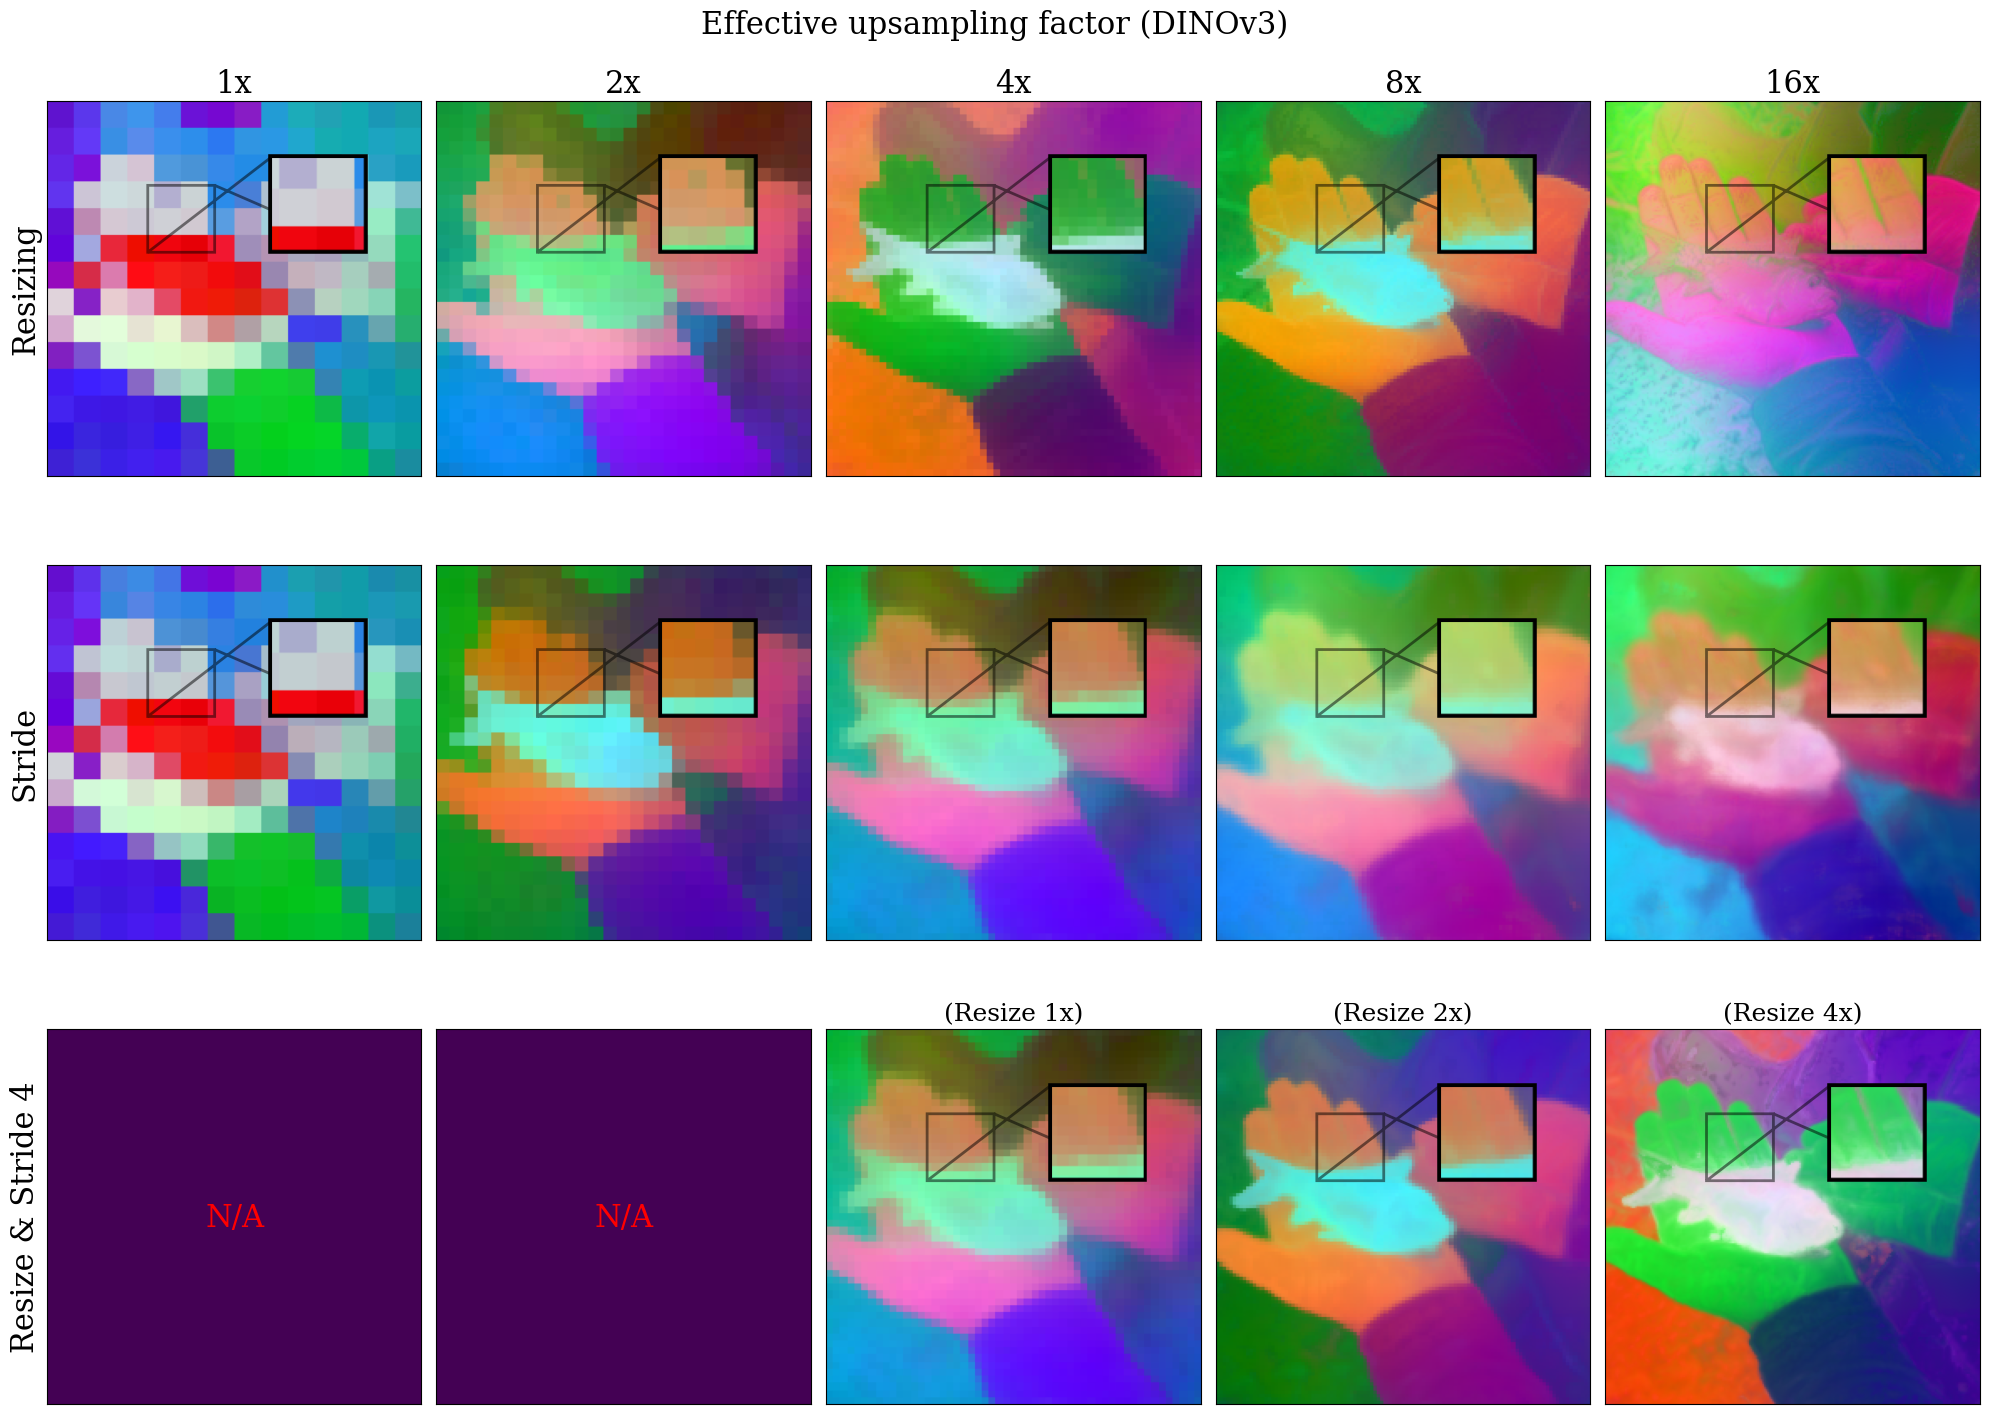

In [ ]:
plt.rcParams["font.family"] = "serif"
FS = 22

fig, axs = plt.subplots(3, len(sizes), figsize=(20, 15))
for i, resize in enumerate(sizes):
    pca = resize_pcas[resize]
    # pca_rescaled = rescale_pca(pca)
    axs[0, i].imshow(pca)
    add_inset_zoom([60, 50, 40, 40], [0.6, 0.6, 0.25, 0.25], pca, axs[0, i])

    axs[0, i].set_title(f"{resize}x", fontsize=FS)
    axs[0, i].set_xticks([])
    axs[0, i].set_yticks([])

axs[0, 0].set_ylabel("Resizing", fontsize=FS)

for i, stride in enumerate(sizes):
    pca = list(stride_pcas.values())[::-1][i]
    # pca_rescaled = rescale_pca(pca)
    axs[1, i].imshow(pca)
    add_inset_zoom([60, 50, 40, 40], [0.6, 0.6, 0.25, 0.25], pca, axs[1, i])

    axs[1, i].set_xticks([])
    axs[1, i].set_yticks([])

axs[1, 0].set_ylabel("Stride", fontsize=FS)


OFFSET = 2
for i, size in enumerate(sizes):
    if i < OFFSET:
        axs[2,  i].set_xticks([])
        axs[2,  i].set_yticks([])
        axs[2, i].imshow(np.ones((h, w)))
        axs[2, i].text(112, 112, 'N/A', horizontalalignment='center', verticalalignment='center', fontsize=FS, color='red')
    else:
        pca = list(resize_stride_pcas.values())[i - OFFSET]
        add_inset_zoom([60, 50, 40, 40], [0.6, 0.6, 0.25, 0.25], pca, axs[2, i])
        # add_inset_zoom([75, 170, 20, 20], [0.8, 0.2, 0.25, 0.25], pca, axs[2, i])
        axs[2, i].imshow(pca)
        axs[2,  i].set_xticks([])
        axs[2,  i].set_yticks([])
        axs[2, i].set_title(f"(Resize {2**(i-OFFSET)}x)", fontsize=FS-4)

axs[2, 0].set_ylabel("Resize & Stride 4", fontsize=FS)
plt.suptitle('Effective upsampling factor (DINOv3)', fontsize=FS)

plt.tight_layout()